# Variational inference using the finite approximation

trying cavi + annealing

In [44]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from copy import deepcopy

from valez_finite_VI_lib import *


# Draw data

In [112]:
# np.random.seed(12321) # this is a seed where annealing works well 
# np.random.seed(43141) # this is a seed that works well too :)
# np.random.seed(341708970) # this too!
np.random.seed(14314) 
# np.random.seed(4234) # this less so ...
# the above were ran for (for K_inf = K_approx = 3 at least) 



Num_samples = 500 # sample size
D = 2 # dimension
# so X will be a N\times D matrix

K_inf = 3 # take to be large for a good approximation to the IBP


alpha = 10 # IBP parameter
Pi = np.ones(K_inf) * .8
Z = np.zeros([Num_samples,K_inf])

# Parameters to draw A from MVN
mu = np.zeros(D)
sigma_A = 100

sigma_eps = .1 # variance of noise

# Draw Z from truncated stick breaking process
for k in range(K_inf):
    # Pi[k] = np.random.beta(alpha/K_inf,1)
    for n in range(Num_samples):
        Z[n,k] = np.random.binomial(1,Pi[k])

        
print('true Z (first 10 rows): \n', Z[0:10,:])

# Draw A from multivariate normal
# A = np.random.multivariate_normal(mu, sigma_A*np.identity(D), K_inf) # FOR SOME REASONG THIS KILLS THE KERNEL!?
A = np.random.normal(0, np.sqrt(sigma_A), (K_inf, D))
print(A)

# draw noise
# epsilon = np.random.multivariate_normal(np.zeros(D), sigma_eps*np.identity(D), Num_samples)
epsilon = np.random.normal(0, sigma_eps, (Num_samples, D))

# the observed data
X = np.dot(Z,A) + epsilon


true Z (first 10 rows): 
 [[ 1.  1.  0.]
 [ 0.  1.  1.]
 [ 1.  1.  0.]
 [ 1.  0.  1.]
 [ 1.  0.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  0.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
[[ 19.62685741  -5.02707654]
 [-19.9694107  -13.80715158]
 [  4.00958547  -2.25505526]]


# set initializations

In [146]:
K_approx = deepcopy(K_inf) # variational truncation

tau = np.random.uniform(0,1,[K_approx,2]) # tau1, tau2 -- beta parameters for v
#tau = np.ones([K_approx,2])*1000
#tau[:,1] = (tau[:,0] - Pi*tau[:,0])/Pi

#nu = np.ones([Num_samples, K_approx]) *0.0
nu =  np.random.uniform(0,1,[Num_samples,K_approx]) # Bernoulli parameter for z_nk
#nu = deepcopy(Z)

phi_mu = np.random.normal(0,1,[D,K_approx]) # kth mean (D dim vector) in kth column
#phi_mu = deepcopy(A).T
phi_var = np.ones(K_approx)

nu_init = np.round(nu*(nu>=0.9) + nu*(nu<=0.1)) + nu*(nu>=0.1)*(nu<=0.9)

iterations = 1000
elbo = np.zeros(iterations)
elbo_Term1 = np.zeros(iterations)
elbo_Term2 = np.zeros(iterations)
elbo_Term3 = np.zeros(iterations)
elbo_Term4 = np.zeros(iterations)
elbo_Term5 = np.zeros(iterations)
elbo_Term6 = np.zeros(iterations)
elbo_Term7 = np.zeros(iterations)


Data_shape = {'D':D, 'N': Num_samples , 'K':K_approx}
sigmas = {'eps': sigma_eps, 'A': sigma_A}


In [147]:
def add_noise_to_phi(phi_mu, noise_scale):
    phi_mu = phi_mu + np.random.normal(0, noise_scale, phi_mu.shape)

# run CAVI

In [148]:
tol = [10**(-4)]*5 + [10**(-6)]*3 + [10**(-8)]*2
print(tol[1])

0.0001


In [164]:
#add_noise_to_phi(phi_mu, 1.0)
sigma_eps_anneal = np.linspace(100, sigma_eps, 10)

for j in range(len(sigma_eps_anneal)): 
    sigmas['eps'] = sigma_eps_anneal[j]
    print('anneal iteration: ', j)
    print(sigmas['eps'])
    
    tol = [10**(-2)]* 2 + [10**(-4)]*3 + [10**(-6)]*3 + [10**(-8)]*2 # set sequence of tolerances
    assert len(tol) == len(sigma_eps_anneal)
    
    elbo = np.zeros(iterations)
    
    for i in range(iterations):
        iter_ran = i + 1
        
        cavi_updates(tau, nu, phi_mu, phi_var, X, alpha, sigmas)
        

        # round_nu = np.round(nu*(nu>=0.9) + nu*(nu<=0.1)) + nu*(nu>=0.1)*(nu<=0.9)

        [elbo[i],elbo_Term1[i],elbo_Term2[i],elbo_Term3[i],elbo_Term4[i],elbo_Term5[i],elbo_Term6[i],\
         elbo_Term7[i]] = compute_elbo(tau, nu, phi_mu, phi_var, X, sigmas, Data_shape, alpha)

        if i%10 ==0:
            nice_iter_display = str(j)+'-'+str(i) # anneal_iter - cavi_iter
            print('iteration: ', nice_iter_display, ' l1 error: ', np.sum(abs(Z-nu))/np.size(Z[:]), \
                 'elbo: ', elbo[i])
        #print(round_nu[0:10,:])
        #print(nu[0:10,:])
        #print('l1 error: ', np.sum(abs(Z-nu))/np.size(Z[:]) )

        if np.isnan(elbo[i]):
            print('NAN ELBO.')
            break

        if (i>0) & (elbo[i] < elbo[i-1]): 
            print('elbo decreased!  Difference: ', elbo[i] - elbo[i-1])
            break
    
        if np.abs(elbo[i]-elbo[i-1]) <= tol[j]:
            print('ELBO converged')
            break


anneal iteration:  0
10.0
iteration:  0-0  l1 error:  0.149247312204 elbo:  -2825.89553201
iteration:  0-10  l1 error:  0.148722511626 elbo:  -2820.54170177
ELBO converged
anneal iteration:  1
8.9
iteration:  1-0  l1 error:  0.148571936717 elbo:  -2790.38519172
ELBO converged
anneal iteration:  2
7.8
iteration:  2-0  l1 error:  0.148375535547 elbo:  -2760.37856861
iteration:  2-10  l1 error:  0.148349292666 elbo:  -2760.35467147
ELBO converged
anneal iteration:  3
6.7
iteration:  3-0  l1 error:  0.148146856791 elbo:  -2731.82239657
iteration:  3-10  l1 error:  0.14812392115 elbo:  -2731.81463079
ELBO converged
anneal iteration:  4
5.6
iteration:  4-0  l1 error:  0.147916029304 elbo:  -2707.88239264
iteration:  4-10  l1 error:  0.147880230042 elbo:  -2707.87205107
ELBO converged
anneal iteration:  5
4.5
iteration:  5-0  l1 error:  0.147598550342 elbo:  -2695.72797919
iteration:  5-10  l1 error:  0.147465301781 elbo:  -2695.69320561
iteration:  5-20  l1 error:  0.147423955311 elbo:  -269

/home/runjing_liu/Documents/BNP/Variational_BNP_robustness/Finite_approx/valez_finite_VI_lib.py:87: RuntimeWarning: overflow encountered in exp
  nu[n,k] = 1./(1.+np.exp(-script_V))


iteration:  9-10  l1 error:  0.146666666667 elbo:  -20085.6295598
iteration:  9-20  l1 error:  0.146666666667 elbo:  -20085.6279913
iteration:  9-30  l1 error:  0.146666666667 elbo:  -20085.6279182
iteration:  9-40  l1 error:  0.146666666667 elbo:  -20085.6279165
ELBO converged


In [165]:
print(elbo[0:iter_ran])

[-20085.68136904 -20085.65951881 -20085.64743581 -20085.6406345
 -20085.6366709  -20085.63423545 -20085.63263766 -20085.63151803
 -20085.63069002 -20085.63005538 -20085.62955984 -20085.62917066
 -20085.62886576 -20085.62862857 -20085.6284458  -20085.62830643
 -20085.62820127 -20085.62812274 -20085.62806469 -20085.62802218
 -20085.62799132 -20085.62796911 -20085.62795325 -20085.62794201
 -20085.6279341  -20085.62792857 -20085.62792473 -20085.62792207
 -20085.62792025 -20085.62791901 -20085.62791817 -20085.6279176
 -20085.62791722 -20085.62791697 -20085.6279168  -20085.62791668
 -20085.62791661 -20085.62791656 -20085.62791653 -20085.62791651
 -20085.6279165  -20085.62791649]


Z (unpermuted): 
 [[ 1.  1.  0.]
 [ 0.  1.  1.]
 [ 1.  1.  0.]
 [ 1.  0.  1.]
 [ 1.  0.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  0.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
** procedure did not give a true permutation
permutation:  [2, 1, 0]
Z (permuted) 
 [[ 0.  1.  1.]
 [ 1.  1.  0.]
 [ 0.  1.  1.]
 [ 1.  0.  1.]
 [ 1.  0.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 0.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
round_nu 
 [[ 1.  1.  1.]
 [ 1.  1.  0.]
 [ 1.  1.  1.]
 [ 1.  0.  1.]
 [ 1.  0.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
l1 error (after permutation):  [0.156, 0.028000000000000001, 0.028000000000000001]


true A (permuted): 
 [[  4.00958547  -2.25505526]
 [-19.9694107  -13.80715158]
 [ 19.62685741  -5.02707654]]
phi_mu: 
 [[  3.05637638  -6.97299845]
 [-19.80939406 -11.09377509]
 [ 19.89188199  -1.92906254]]


true Pi (permuted):  [ 0.8  0.8  0.8]
computed Pi:  [ 0.90284204  0.83344349  0.85723728]


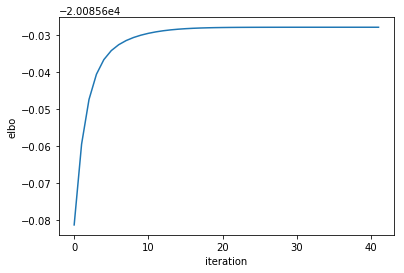

In [166]:
Pi_computed = tau[:,0]/(tau[:,0] + tau[:,1])
round_nu = np.round(nu*(nu>=0.9) + nu*(nu<=0.1)) + nu*(nu>=0.1)*(nu<=0.9)
print('Z (unpermuted): \n', Z[0:10])

# Find the minimizing permutation.
accuracy_mat = [[ np.sum(np.abs(Z[:, i] - nu[:, j]))/Num_samples for i in range(K_inf) ]
                  for j in range(K_inf) ]
perm_tmp = np.argmin(accuracy_mat, 1)

if len(perm_tmp) == len(set(perm_tmp)):  # check that we have a true permuation
    perm = np.argmin(accuracy_mat, 1)
else: 
    print('** procedure did not give a true permutation')
    perm = [0,1,2]
perm = [2,1,0]
print('permutation: ', perm)
    
# print Z (permuted) and nu
print('Z (permuted) \n', Z[0:10, perm])
print('round_nu \n', round_nu[0:10,:])

print('l1 error (after permutation): ', \
      [ np.sum(np.abs(Z[:, perm[i]] - nu[:, i]))/Num_samples for i in range(K_inf) ])

print('\n')
print('true A (permuted): \n', A[perm, :])
print('phi_mu: \n', phi_mu.transpose())

print('\n')
print('true Pi (permuted): ', Pi)
print('computed Pi: ', Pi_computed)
plt.clf()
plt.plot(elbo[:iter_ran])
plt.xlabel('iteration')
plt.ylabel('elbo')
plt.show()

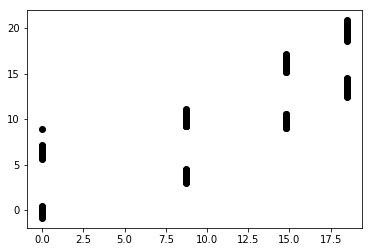

In [112]:
pred_x = np.dot(nu, phi_mu.transpose())
col = 1
plt.clf()
plt.plot(pred_x[:, col], X[:, col], 'ko')
plt.show()

In [109]:
# let us permute the columms of nu and then compare: 
nu_perm = nu[:, (1,2,0)]
round_nu_perm = np.round(nu_perm*(nu_perm>=0.9) + nu_perm*(nu_perm<=0.1)) + nu_perm*(nu_perm>=0.1)*(nu_perm<=0.9)

print(np.sum(np.abs(Z[:,0] - nu_perm[:,0]))/Num_samples)
print(np.sum(np.abs(Z[:,1] - nu_perm[:,1]))/Num_samples)
print(np.sum(np.abs(Z[:,2] - nu_perm[:,2]))/Num_samples)

# so two of the rows are really close ...

0.9566
0.1538
0.706
